In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr, pearsonr
from matplotlib.colors import PowerNorm
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [61]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,0.0,cluster0,simple,NaN


In [62]:
df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)


df_off['off-period'] = df_off['off-period'].astype(int)
df_off = pd.merge(df_off, df.drop('off-period', axis=1), on=["gene", "celltype"])
df_off.shape

(7415, 44)

# add cut&tag value

In [63]:
gene_celltype, celltype = "HBEC", "HBEC"
# gene_celltype, celltype = "H9D0",  "ESC_D0"
# gene_celltype, celltype = "H9D3",  "ESC_D3"

data = df_off[df_off["celltype"]==gene_celltype]
data = data[["gene", "celltype", "off-period"]]
data.shape

(5347, 3)

In [64]:
data.head(1)

,gene,celltype,off-period
0,LUZP1,HBEC,213


In [65]:
# Define your files along with the corresponding score type (genebody or tss)
files = [
    f"{celltype}_ATAC_genebody.tab", f"{celltype}_ATAC_tss.tab",
    f"{celltype}_H3K27ac_genebody.tab", f"{celltype}_H3K27ac_tss.tab",
    f"{celltype}_H3K36me3_genebody.tab", f"{celltype}_H3K36me3_tss.tab",
    f"{celltype}_H3K4me1_genebody.tab", f"{celltype}_H3K4me1_tss.tab",
    f"{celltype}_H3K4me3_genebody.tab", f"{celltype}_H3K4me3_tss.tab",
    f"{celltype}_H3K9me3_genebody.tab", f"{celltype}_H3K9me3_tss.tab",
    f"{celltype}_H3K27me3_genebody.tab", f"{celltype}_H3K27me3_tss.tab"
]

# Assuming df_wan is your initial DataFrame
for file in files:
    parts = file.split('_')
    mark = parts[-2]
    #mark = '_'.join(parts[1:-1])  # e.g., H3K27ac
    region = parts[-1].split('.')[0]  # e.g., genebody or tss

    # Construct the score column name
    score_column_name = f"{mark}_{region}_mean"  # e.g., H3K27ac_genebody_mean

    # Read the file
    df_temp = pd.read_csv(f"~/projects/transcriptome_4D/data/gene_property/{file}", header=None, sep='\t',
                          names=["gene", "size", "covered", "total", "mean0", score_column_name])

    # Extract only the 'gene_full' and the score column
    df_temp = df_temp[["gene", score_column_name]]

    # Merge with df_wan
    data = pd.merge(data, df_temp, on="gene")
data.shape

(5347, 17)

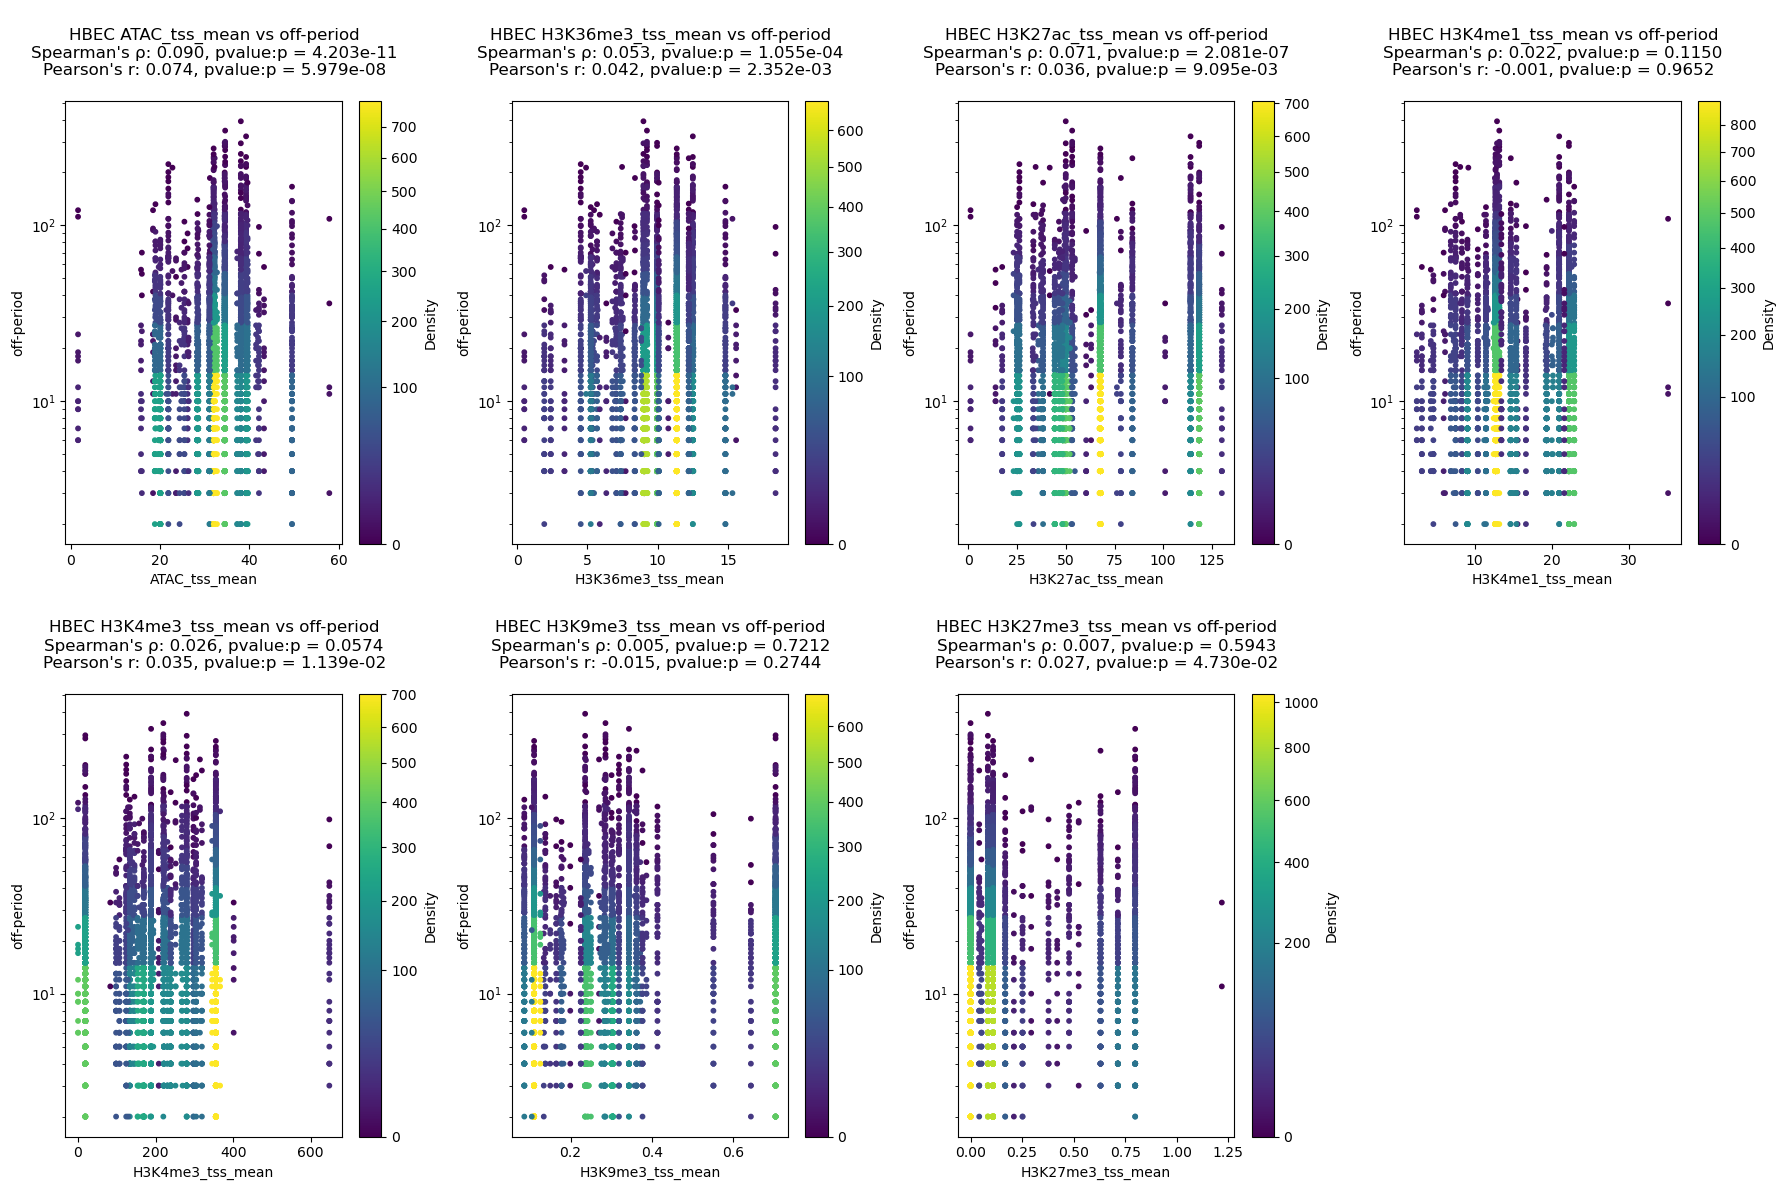

In [66]:
def calculate_point_density(x, y, bins=30):
    xy = np.vstack([x, y])
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    xidx = np.clip(np.digitize(x, xedges) - 1, 0, bins - 1)
    yidx = np.clip(np.digitize(y, yedges) - 1, 0, bins - 1)
    return hist[xidx, yidx]


# Define the columns for plotting
columns = ['ATAC_tss_mean',
           'H3K36me3_tss_mean',
           'H3K27ac_tss_mean',
           'H3K4me1_tss_mean',
           'H3K4me3_tss_mean', 
           'H3K9me3_tss_mean',
           'H3K27me3_tss_mean',
          ]

plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    
    # Calculate Spearman's and Pearson's correlation coefficients
    spearman_corr, spearman_pval = spearmanr(data[col], data['off-period'])
    pearson_corr, pearson_pval = pearsonr(data[col], data['off-period'])
    spearman_pval = f'p = {spearman_pval:.3e}' if spearman_pval < 0.05 else f'p = {spearman_pval:.4f}'
    pearson_pval = f'p = {pearson_pval:.3e}' if pearson_pval < 0.05 else f'p = {pearson_pval:.4f}'
    
    ax = plt.subplot(2, 4, i + 1)
    
    z = calculate_point_density(data[col], data['off-period'])
    
    sc = ax.scatter(data[col], data['off-period'], c=z, cmap='viridis', norm=PowerNorm(0.5), s=10)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Density')
    
    # Set axis labels and title
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('off-period')
    ax.set_title(f"""
    {celltype} {col} vs off-period
    Spearman's ρ: {spearman_corr:.3f}, pvalue:{spearman_pval}
    Pearson's r: {pearson_corr:.3f}, pvalue:{pearson_pval}
    """)


plt.tight_layout()
plt.show()



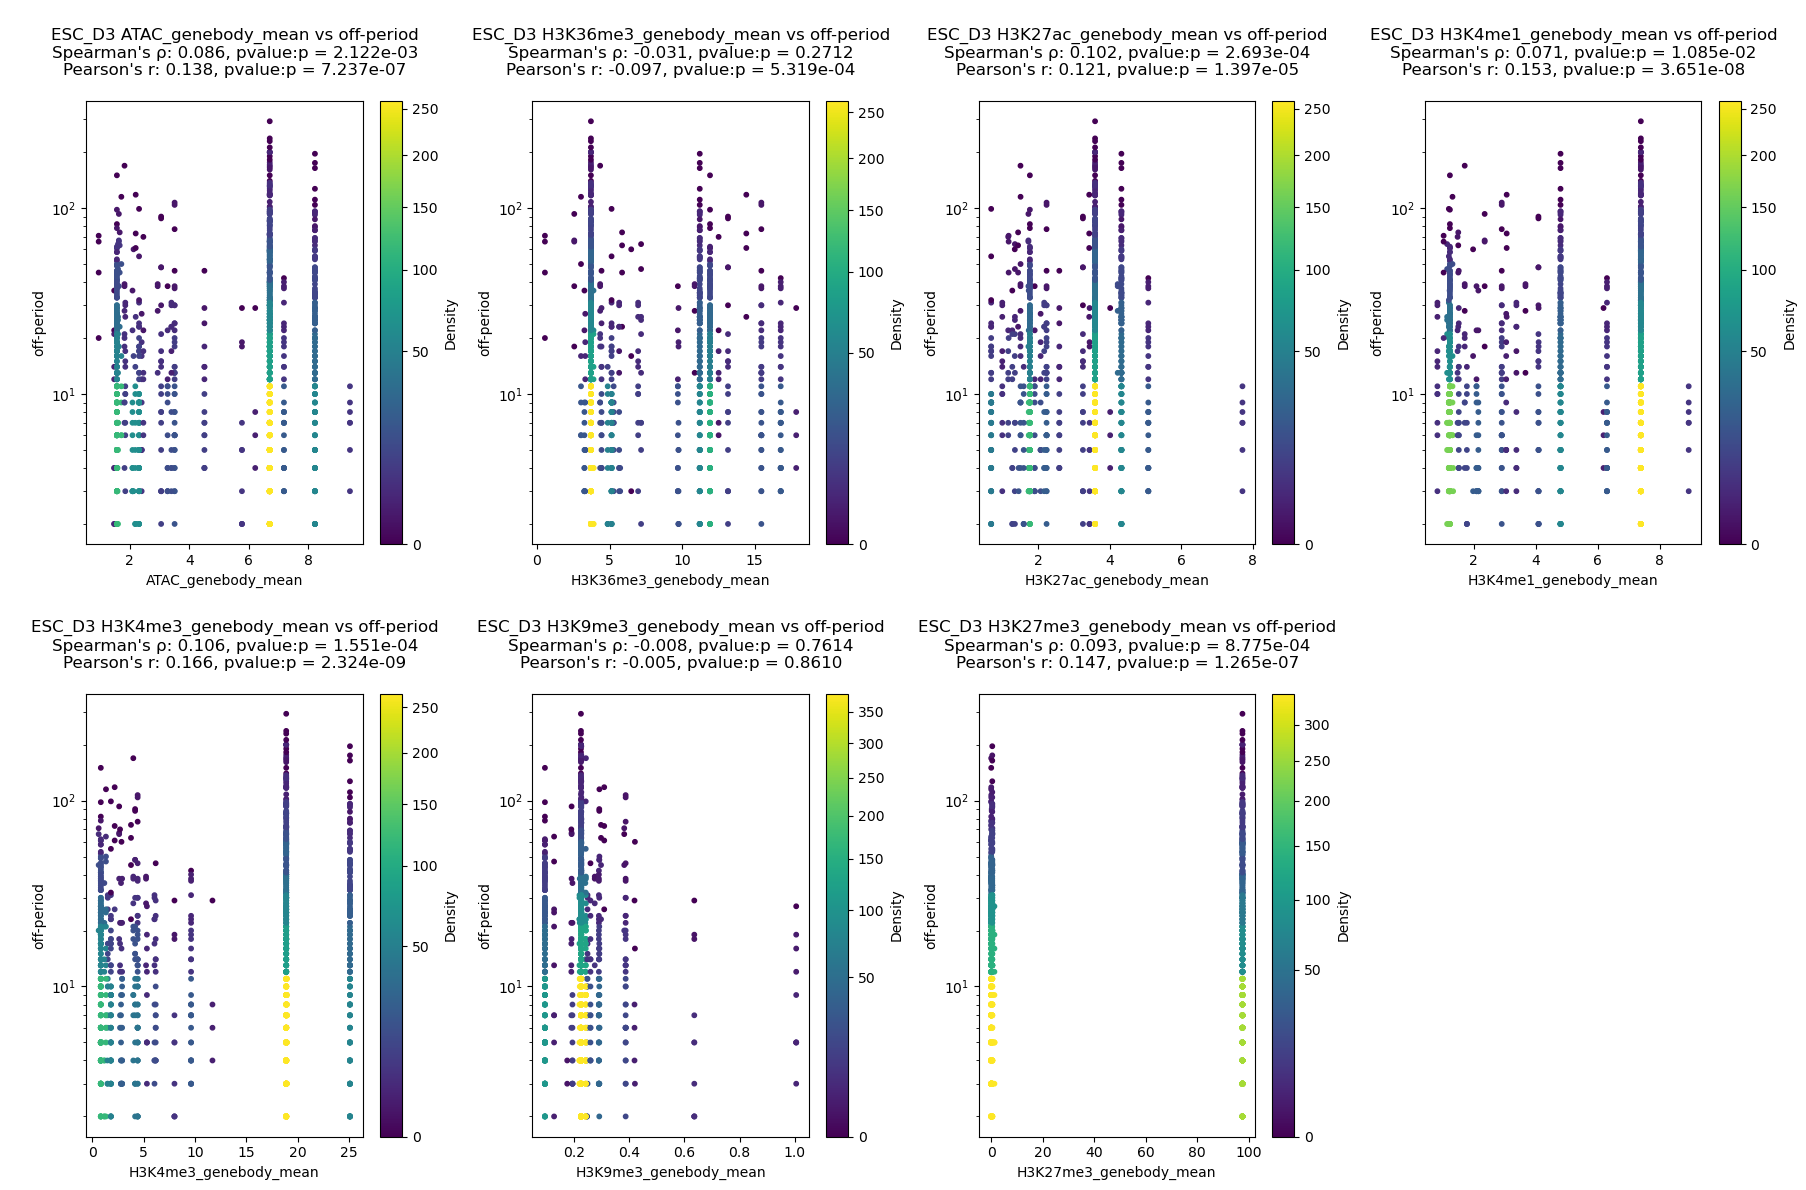

In [60]:
columns = ['ATAC_genebody_mean',
           'H3K36me3_genebody_mean',
           
           'H3K27ac_genebody_mean',
           'H3K4me1_genebody_mean',
           'H3K4me3_genebody_mean', 
           'H3K9me3_genebody_mean',
           'H3K27me3_genebody_mean',
          ]


plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    
    # Calculate Spearman's and Pearson's correlation coefficients
    spearman_corr, spearman_pval = spearmanr(data[col], data['off-period'])
    pearson_corr, pearson_pval = pearsonr(data[col], data['off-period'])
    spearman_pval = f'p = {spearman_pval:.3e}' if spearman_pval < 0.05 else f'p = {spearman_pval:.4f}'
    pearson_pval = f'p = {pearson_pval:.3e}' if pearson_pval < 0.05 else f'p = {pearson_pval:.4f}'
    
    
    ax = plt.subplot(2, 4, i + 1)
    
    z = calculate_point_density(data[col], data['off-period'])
    
    sc = ax.scatter(data[col], data['off-period'], c=z, cmap='viridis', norm=PowerNorm(0.5), s=10)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Density')
    
    # Set axis labels and title
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('off-period')
    ax.set_title(f"""
    {celltype} {col} vs off-period
    Spearman's ρ: {spearman_corr:.3f}, pvalue:{spearman_pval}
    Pearson's r: {pearson_corr:.3f}, pvalue:{pearson_pval}
    """)

plt.tight_layout()
plt.show()
